# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Enter The Frontier!

And now - we put Frontier Models to the test.

### 2 important points:

It's important to appreciate that we aren't Training the frontier models. We're only providing them with the Test dataset to see how they perform. They don't gain the benefit of the 400,000 training examples that we provided to the Traditional ML models.

HAVING SAID THAT...

It's entirely possible that in their monstrously large training data, they've already been exposed to all the products in the training AND the test set. So there could be test "contamination" here which gives them an unfair advantage. We should keep that in mind.

In [1]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic

In [2]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from testing import Tester

In [3]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
openai = OpenAI()
claude = Anthropic()

In [6]:
%matplotlib inline

In [7]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

# Before we look at the Frontier

## There is one more model we could consider

In [16]:
# Write the test set to a CSV

import csv
with open('human_input.csv', 'w', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    for t in test[:250]:
        writer.writerow([t.test_prompt(), 0])

In [17]:
# Read it back in

human_predictions = []
with open('human_output.csv', 'r', encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[1]))

In [18]:
def human_pricer(item):
    idx = test.index(item)
    return human_predictions[idx]

1: Guess: $120.00 Truth: $174.35 Error: $54.35 SLE: 0.14 Item: Cardone 12-2006 Remanufactured Anti-Lock...
2: Guess: $80.00 Truth: $169.99 Error: $89.99 SLE: 0.56 Item: Sony RDR-GX355 Tunerless DVD Recorder
3: Guess: $35.00 Truth: $769.00 Error: $734.00 SLE: 9.38 Item: 2022 Newest HP 17t Laptop, 17.3" HD+ Tou...
4: Guess: $350.00 Truth: $134.54 Error: $215.46 SLE: 0.91 Item: Alert FTL230 Bench Lamp with Dual 220 Lu...
5: Guess: $75.00 Truth: $179.99 Error: $104.99 SLE: 0.75 Item: VocoPro TabletOke-II Digital Karaoke Mix...
6: Guess: $12.00 Truth: $201.41 Error: $189.41 SLE: 7.54 Item: For Ford Expedition & Lincoln Navigator ...
7: Guess: $115.00 Truth: $338.31 Error: $223.31 SLE: 1.15 Item: Skunk2 Racing 344-05-1300 Alpha Valve Sp...
8: Guess: $100.00 Truth: $2.56 Error: $97.44 SLE: 11.19 Item: Timberline - 1/4" Diameter Brad Pt. Wood...
9: Guess: $300.00 Truth: $134.54 Error: $165.46 SLE: 0.64 Item: 8 Pcs Kit Front Inner Outer Tie Rod Ends...
10: Guess: $80.00 Truth: $161.04 Error: $8

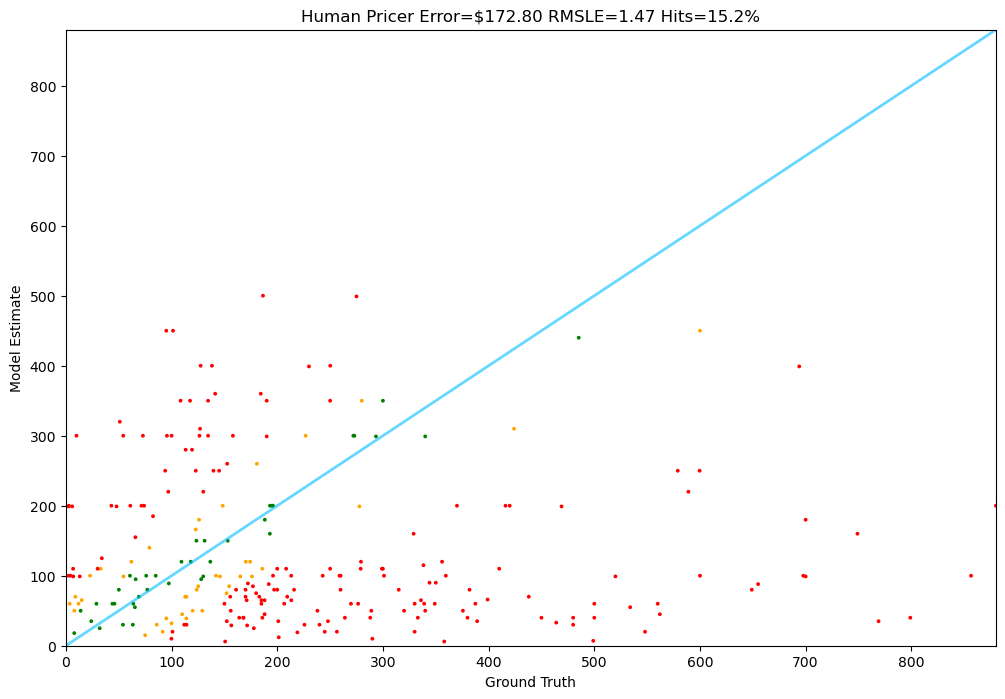

In [19]:
Tester.test(human_pricer, test)

## First, the humble but mighty GPT-4o-mini

It's called mini, but it packs a punch.

In [20]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [21]:
# Try this out

messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nCardone Remanufactured Anti-Lock Brakes ABS Hydraulic Assembly Unit (Renewed)\nCARDONE Remanufactured ABS Control Modules are designed to meet or exceed O.E. performance. Reverse engineering provides insight into how and why the unit originally failed, allowing our engineers to identify and correct original design flaws. Every CARDONE unit goes through stringent testing, ensuring like-new performance and quick reaction time when traction control is required. As a remanufactured Original Equipment part, this unit assures a perfect vehicle fit All modules are fully tested with automated computerized test equipment to ensure functionality and reliable High-pressure hydraulic testing ensures zero leakage for long-lasting performance; field testing further ensures product reliability Air-decay testing ensures zero brake flui

In [22]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [23]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [24]:
# The function for gpt-4o-mini

def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [25]:
test[0].price

174.35

1: Guess: $250.00 Truth: $174.35 Error: $75.65 SLE: 0.13 Item: Cardone 12-2006 Remanufactured Anti-Lock...
2: Guess: $199.99 Truth: $169.99 Error: $30.00 SLE: 0.03 Item: Sony RDR-GX355 Tunerless DVD Recorder
3: Guess: $749.99 Truth: $769.00 Error: $19.01 SLE: 0.00 Item: 2022 Newest HP 17t Laptop, 17.3" HD+ Tou...
4: Guess: $39.99 Truth: $134.54 Error: $94.55 SLE: 1.43 Item: Alert FTL230 Bench Lamp with Dual 220 Lu...
5: Guess: $199.99 Truth: $179.99 Error: $20.00 SLE: 0.01 Item: VocoPro TabletOke-II Digital Karaoke Mix...
6: Guess: $129.99 Truth: $201.41 Error: $71.42 SLE: 0.19 Item: For Ford Expedition & Lincoln Navigator ...
7: Guess: $299.99 Truth: $338.31 Error: $38.32 SLE: 0.01 Item: Skunk2 Racing 344-05-1300 Alpha Valve Sp...
8: Guess: $10.99 Truth: $2.56 Error: $8.43 SLE: 1.47 Item: Timberline - 1/4" Diameter Brad Pt. Wood...
9: Guess: $150.00 Truth: $134.54 Error: $15.46 SLE: 0.01 Item: 8 Pcs Kit Front Inner Outer Tie Rod Ends...
10: Guess: $179.99 Truth: $161.04 Error: $18.95 

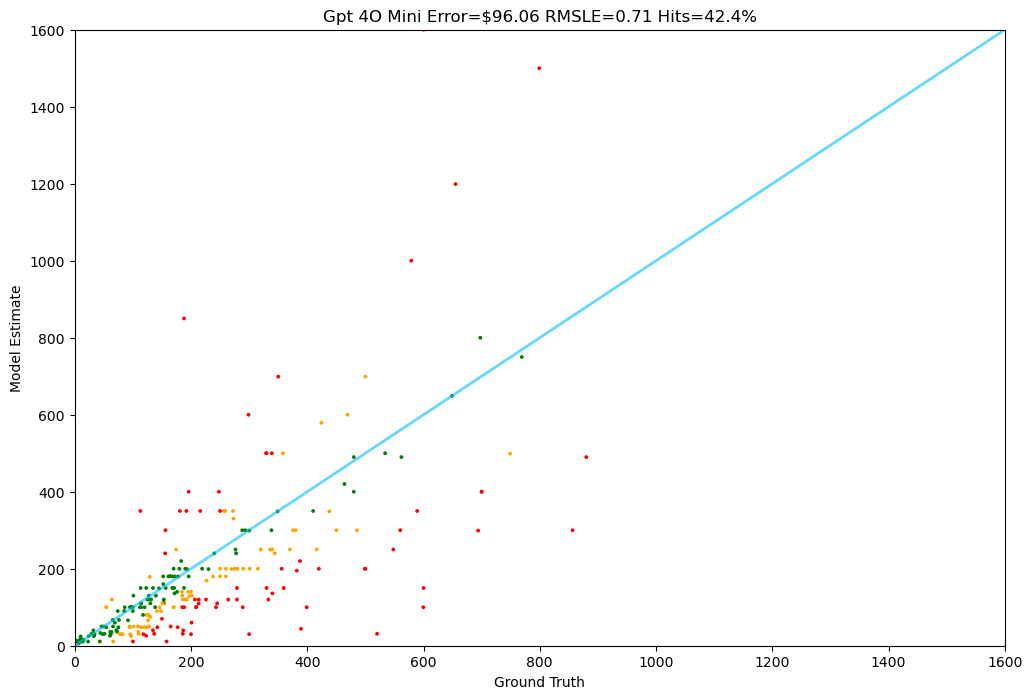

In [26]:
Tester.test(gpt_4o_mini, test)

In [27]:
def gpt_4o_frontier(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $210.00 Truth: $174.35 Error: $35.65 SLE: 0.03 Item: Cardone 12-2006 Remanufactured Anti-Lock...
2: Guess: $150.00 Truth: $169.99 Error: $19.99 SLE: 0.02 Item: Sony RDR-GX355 Tunerless DVD Recorder
3: Guess: $800.00 Truth: $769.00 Error: $31.00 SLE: 0.00 Item: 2022 Newest HP 17t Laptop, 17.3" HD+ Tou...
4: Guess: $0.00 Truth: $134.54 Error: $134.54 SLE: 24.10 Item: Alert FTL230 Bench Lamp with Dual 220 Lu...
5: Guess: $179.00 Truth: $179.99 Error: $0.99 SLE: 0.00 Item: VocoPro TabletOke-II Digital Karaoke Mix...
6: Guess: $250.00 Truth: $201.41 Error: $48.59 SLE: 0.05 Item: For Ford Expedition & Lincoln Navigator ...
7: Guess: $450.00 Truth: $338.31 Error: $111.69 SLE: 0.08 Item: Skunk2 Racing 344-05-1300 Alpha Valve Sp...
8: Guess: $7.47 Truth: $2.56 Error: $4.91 SLE: 0.75 Item: Timberline - 1/4" Diameter Brad Pt. Wood...
9: Guess: $120.00 Truth: $134.54 Error: $14.54 SLE: 0.01 Item: 8 Pcs Kit Front Inner Outer Tie Rod Ends...
10: Guess: $150.00 Truth: $161.04 Error: $11.04 

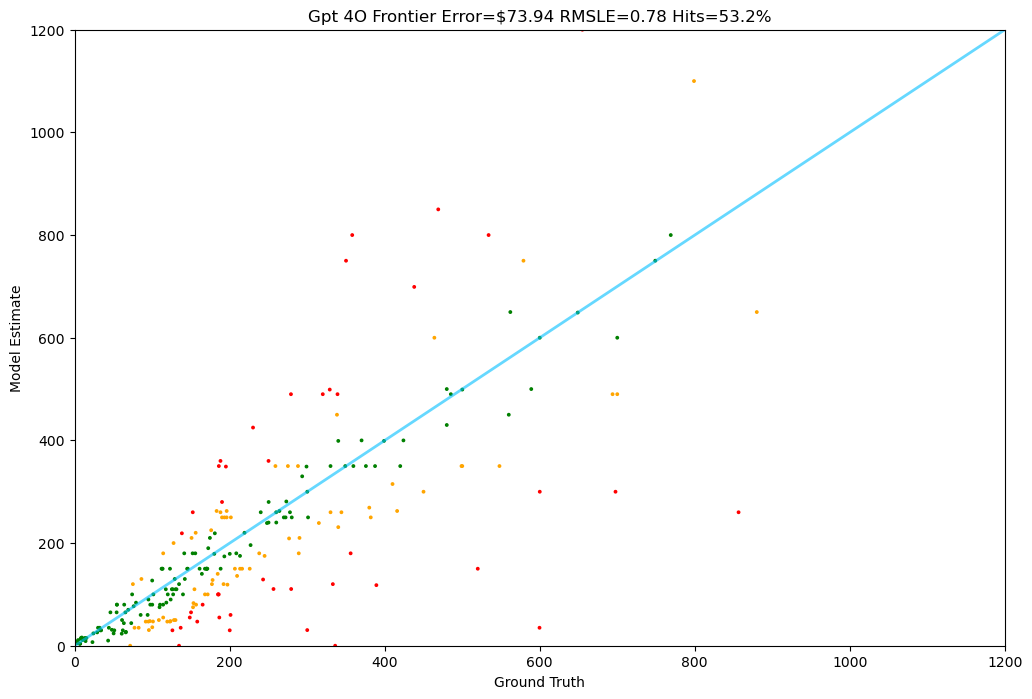

In [29]:
# The function for gpt-4o - the August model
# Note that it cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

Tester.test(gpt_4o_frontier, test)

In [30]:
def claude_3_point_5_sonnet(item):
    messages = messages_for(item)
    system_message = messages[0]['content']
    messages = messages[1:]
    response = claude.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=5,
        system=system_message,
        messages=messages
    )
    reply = response.content[0].text
    return get_price(reply)

1: Guess: $79.99 Truth: $174.35 Error: $94.36 SLE: 0.60 Item: Cardone 12-2006 Remanufactured Anti-Lock...
2: Guess: $199.99 Truth: $169.99 Error: $30.00 SLE: 0.03 Item: Sony RDR-GX355 Tunerless DVD Recorder
3: Guess: $649.99 Truth: $769.00 Error: $119.01 SLE: 0.03 Item: 2022 Newest HP 17t Laptop, 17.3" HD+ Tou...
4: Guess: $39.99 Truth: $134.54 Error: $94.55 SLE: 1.43 Item: Alert FTL230 Bench Lamp with Dual 220 Lu...
5: Guess: $169.99 Truth: $179.99 Error: $10.00 SLE: 0.00 Item: VocoPro TabletOke-II Digital Karaoke Mix...
6: Guess: $139.99 Truth: $201.41 Error: $61.42 SLE: 0.13 Item: For Ford Expedition & Lincoln Navigator ...
7: Guess: $409.99 Truth: $338.31 Error: $71.68 SLE: 0.04 Item: Skunk2 Racing 344-05-1300 Alpha Valve Sp...
8: Guess: $14.99 Truth: $2.56 Error: $12.43 SLE: 2.26 Item: Timberline - 1/4" Diameter Brad Pt. Wood...
9: Guess: $149.99 Truth: $134.54 Error: $15.45 SLE: 0.01 Item: 8 Pcs Kit Front Inner Outer Tie Rod Ends...
10: Guess: $99.99 Truth: $161.04 Error: $61.05 

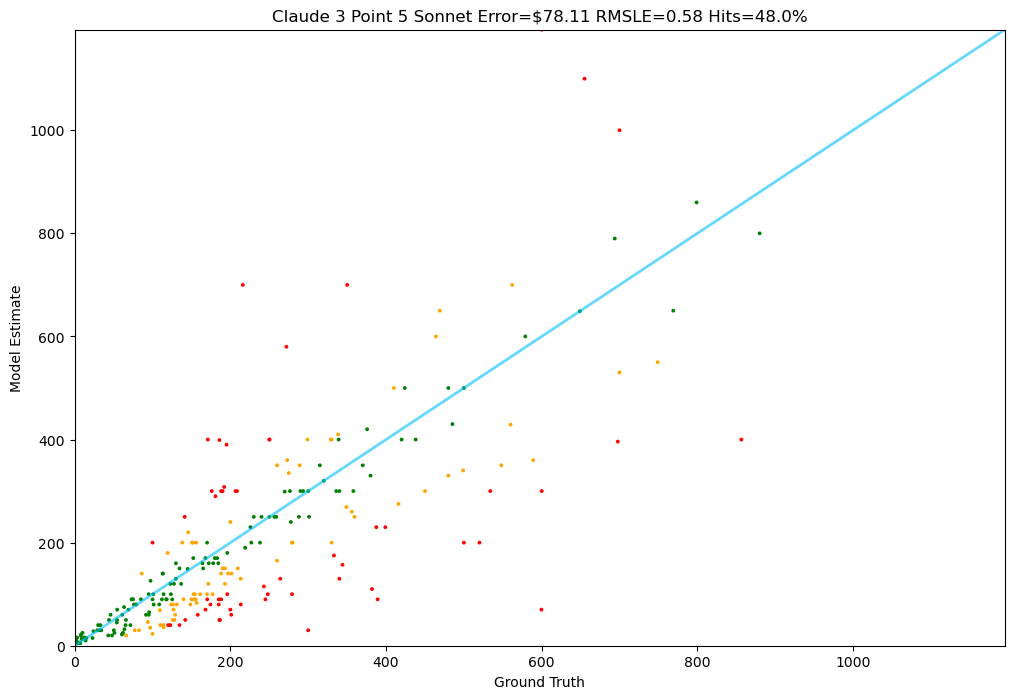

In [31]:
# The function for Claude 3.5 Sonnet
# It also cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

Tester.test(claude_3_point_5_sonnet, test)